<a href="https://colab.research.google.com/github/nicolycosta/VARMA/blob/main/VARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vector Autoregressive Moving-Average (VARMA) 
 Variáveis usadas: \
    IPVA \
    IGP-DI

In [10]:
# Bibliotecas
import copy
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_percentage_error

In [14]:
serie = pd.read_excel("IPVA.xlsx")
serie['Mês'] = pd.to_datetime(serie['Mês']) 
serie = serie.set_index('Mês')
serie

,IPVA,IGP-DI
Mês,,
2004-01-01,3292584.55,293.793
2004-02-01,3624237.38,296.976
2004-03-01,10141637.49,299.746
2004-04-01,7972884.99,303.184
2004-05-01,7146505.74,307.616
...,...,...
2021-05-01,79294916.85,1055.167
2021-06-01,95590000.00,1056.343
2021-07-01,83650460.45,1071.615


## **Teste de Causalidade de Granger e Correlação Cruzada**

In [21]:
#### Correlação Cruzada
a= sm.tsa.stattools.ccf(serie['IGP-DI'], serie['IPVA'])
print(a[1:10])

[0.8813508  0.8677445  0.84451154 0.81208138 0.7908897  0.77627828
 0.76102182 0.75943141 0.76368572]


In [22]:
#### Teste de Causalidade de Granger
import statsmodels.api as sm
import statsmodels.tsa.stattools
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [23]:
grangers_causation_matrix(serie, variables = serie.columns) 

,IPVA_x,IGP-DI_x
IPVA_y,1.0000,0.0
IGP-DI_y,0.0001,1.0


## **Separação em modelagem e teste**

In [24]:
nSamples = len(serie) # Número total de amostras na série.
nTestSamples = 9     # Número de amostras definidas para teste. Nesse caso, 9 amostras.
nModelSamples = nSamples - nTestSamples     # Número de amostras definidas para modelagem
serieModel = serie.iloc[:nModelSamples]
serieTest = serie.iloc[nModelSamples:]

print(f'Número de amostras: {nSamples}')
print(f'Número de amostras para modelagem: {nModelSamples}')
print(f'Número de amostras para teste: {nTestSamples}')
print(f'Os dados de modelagem começam em {serieModel.index[0].year}-{serieModel.index[0].month} e terminam em {serieModel.index[nModelSamples - 1].year}-{serieModel.index[nModelSamples - 1].month}.')
print(f'Os dados de teste começam em {serieTest.index[0].year}-{serieTest.index[0].month} e terminam em {serieTest.index[nTestSamples - 1].year}-{serieTest.index[nTestSamples - 1].month}.')

Número de amostras: 213
Número de amostras para modelagem: 204
Número de amostras para teste: 9
Os dados de modelagem começam em 2004-1 e terminam em 2020-12.
Os dados de teste começam em 2021-1 e terminam em 2021-9.


## **Verificação de Estacionariedade**

### Função de Autocorrelação Amostral

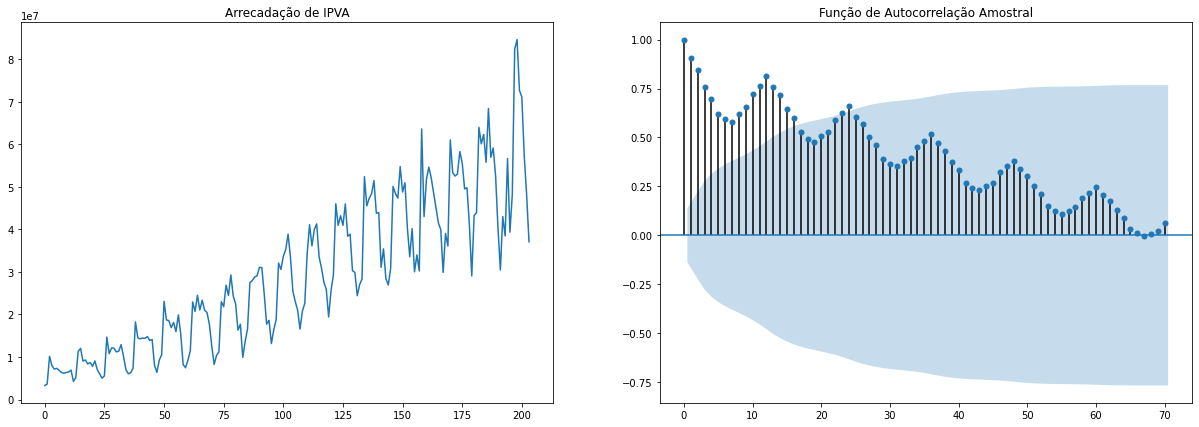

In [25]:
#### Variável endógena: ICMS

icms = serieModel['IPVA'].values 

plt.figure(figsize = (21, 7))
plt.subplot(1,2,1)
plt.plot(icms)
plt.title('Arrecadação de IPVA')

ax2 = plt.subplot(1,2,2)
plot_acf(icms, lags=70, title = 'Função de Autocorrelação Amostral',  alpha = 0.05, ax = ax2)

plt.show()

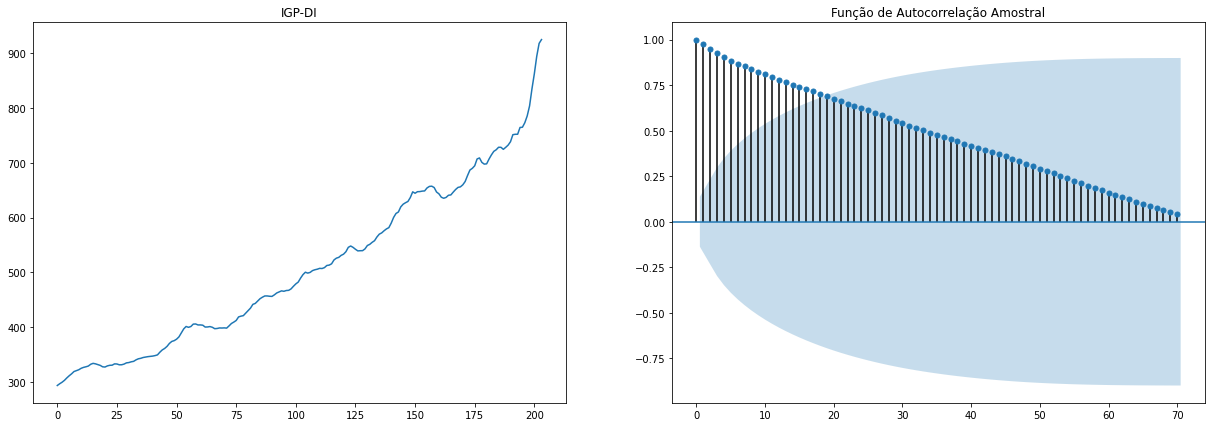

In [26]:
#### Variável endógena: IGP-DI

ipca = serieModel['IGP-DI'].values 

plt.figure(figsize = (21, 7))
plt.subplot(1,2,1)
plt.plot(ipca)
plt.title('IGP-DI')

ax2 = plt.subplot(1,2,2)
plot_acf(ipca, lags=70, title = 'Função de Autocorrelação Amostral',  alpha = 0.05, ax = ax2)

plt.show()